In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from pgmpy.models import BayesianNetwork

from pgmpy.estimators import ParameterEstimator
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.estimators import BayesianEstimator
from pgmpy.factors.discrete.CPD import TabularCPD

# Structure Learning
from pgmpy.base import DAG
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BDeuScore
import networkx as nx

from sklearn.metrics import classification_report, confusion_matrix

from pgmpy.inference import VariableElimination

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from sklearn.preprocessing import LabelEncoder

# Loading Data

In [2]:
df_train = pd.read_csv('./Data/cardiovascular_train.csv')
df_test = pd.read_csv('./Data/cardiovascular_test.csv')

### Applying SMOTE to Diabetes Column

In [3]:
categorical_columns = ['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',   # All Exept SocioeconomicStatus
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile']


In [4]:
X_train = df_train.drop('Diabetes', axis=1)
y_train = df_train['Diabetes']
X_test = df_test.drop('Diabetes', axis=1)
y_test = df_test['Diabetes']

In [5]:
categorical_feature_indices = [X_train.columns.get_loc(col) for col in categorical_columns if col != 'Diabetes']

smote_nc = SMOTENC(categorical_features=categorical_feature_indices, random_state=42, sampling_strategy=0.2)

X_train_resampled, y_resampled = smote_nc.fit_resample(X_train, y_train)

In [6]:
print(y_train.value_counts())
print(y_resampled.value_counts())

Diabetes
No     3669
Yes     176
Name: count, dtype: int64
Diabetes
No     3669
Yes     733
Name: count, dtype: int64


# Visualizing Data

In [7]:
print(df_train.columns)
df_train.head()

Index(['Age', 'Anxiety', 'BodyMassIndex', 'Depression', 'Diabetes',
       'EducationLevel', 'Hypercholesterolemia', 'Hypertension',
       'PhysicalActivity', 'Sex', 'SleepDuration', 'SmokerProfile',
       'SocioeconomicStatus'],
      dtype='object')


,Age,Anxiety,BodyMassIndex,Depression,Diabetes,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus
0,54-64,No,Overweight,No,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3
1,24-34,No,Obese,No,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3
2,24-34,No,Overweight,No,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1
3,34-44,No,Overweight,No,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3
4,44-54,No,Overweight,No,Yes,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3


# Structure Learning - Creating a DAG

## With No SMOTE

In [8]:
nodes = set(df_train.columns)
root_nodes = ['Age', 'Sex']
impossible_connections = []

for root_node in root_nodes:
    for node in nodes:
        connection = (node, root_node)
        impossible_connections.append(connection)

blacklist = set(impossible_connections)

In [9]:
def initialize_graph(nodes, p=1, blacklist=[]):
    G = DAG()
    G.add_nodes_from(nodes=nodes)
    init = G.get_random(n_nodes=len(nodes), edge_prob=p)
    ls = []
    mapping = {k: nodes[k] for k in range(len(nodes))}
    for i, j in init.edges:
        edge = (mapping[i], mapping[j])
        if edge not in blacklist:
            ls.append(edge)
    G.add_edges_from(ebunch=ls)
    return G

In [10]:
score_metric = BDeuScore(df_train)
es = HillClimbSearch(df_train)

In [11]:
rand_list = [random.randrange(3, 7) for _ in range(0,15)]
rand_list = [x/10 for x in rand_list]
best_eval = 0
for x, y in zip(range(0,15), rand_list):
    current_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_eval = score_metric.score(current_model)
    print(curr_eval)
    if curr_eval < best_eval:
        best_eval = curr_eval
        best_model = current_model

print(best_eval)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-31685.21677406304


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31556.04307310933


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31632.78549353079


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31601.10400075266


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31597.211122492685


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31728.089345115113


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31756.596256820583


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31665.979470354425


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31568.182185196576


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31704.351765700332


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31747.6305140227


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31623.145409276727


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31723.270489113333


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31630.082953083565


  0%|          | 0/1000000 [00:00<?, ?it/s]

-31526.88310078816
-31756.596256820583


[('EducationLevel', 'Depression'), ('Age', 'Hypertension'), ('Age', 'PhysicalActivity'), ('Age', 'BodyMassIndex'), ('Age', 'SmokerProfile'), ('Age', 'EducationLevel'), ('Age', 'Hypercholesterolemia'), ('Anxiety', 'SleepDuration'), ('Hypertension', 'Diabetes'), ('Hypertension', 'Hypercholesterolemia'), ('Hypertension', 'Anxiety'), ('PhysicalActivity', 'Depression'), ('PhysicalActivity', 'SmokerProfile'), ('SocioeconomicStatus', 'EducationLevel'), ('Hypercholesterolemia', 'SmokerProfile'), ('Diabetes', 'PhysicalActivity'), ('Diabetes', 'Hypercholesterolemia'), ('Depression', 'SleepDuration'), ('Sex', 'PhysicalActivity'), ('Sex', 'Anxiety'), ('SmokerProfile', 'BodyMassIndex'), ('BodyMassIndex', 'EducationLevel'), ('BodyMassIndex', 'SocioeconomicStatus')]


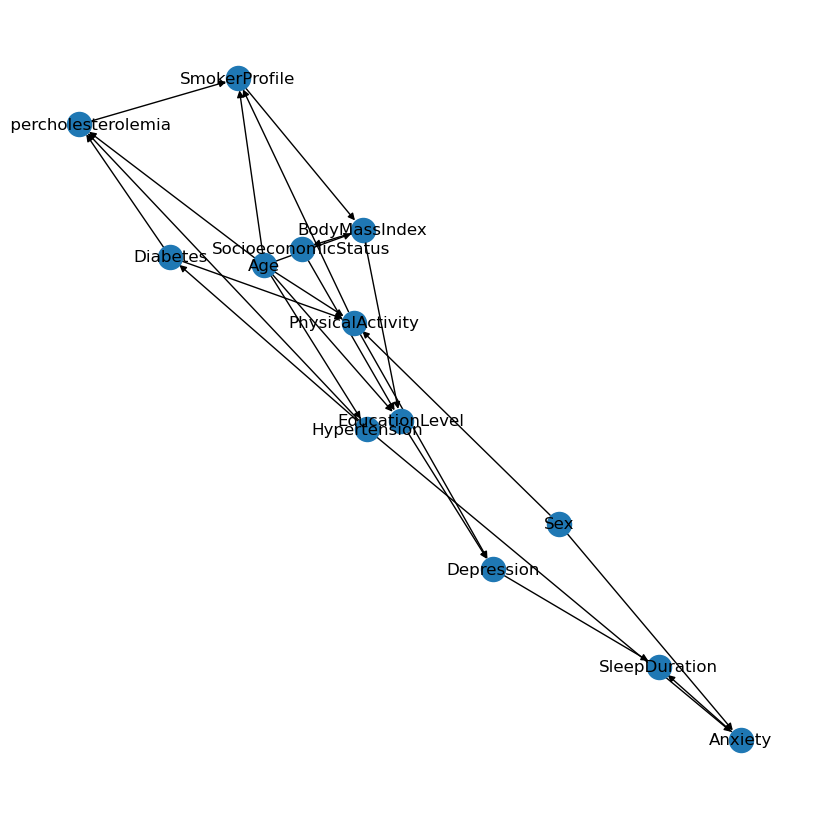

In [12]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_model.edges()), with_labels=True)
plt.draw()
print(best_model.edges())

## With SMOTE

In [13]:
df_resampled = X_train_resampled
df_resampled['Diabetes'] = y_resampled

In [14]:
df_resampled.head()

,Age,Anxiety,BodyMassIndex,Depression,EducationLevel,Hypercholesterolemia,Hypertension,PhysicalActivity,Sex,SleepDuration,SmokerProfile,SocioeconomicStatus,Diabetes
0,54-64,No,Overweight,No,2,No,No,Regularly Active,Male,6-9hours,Smoker,3,No
1,24-34,No,Obese,No,3,Yes,No,Regularly Active,Female,6-9hours,Non_Smoker,3,No
2,24-34,No,Overweight,No,2,No,No,Insufficiently Active,Male,6-9hours,Non_Smoker,1,No
3,34-44,No,Overweight,No,2,Yes,Yes,Regularly Active,Male,<6hours,Non_Smoker,3,No
4,44-54,No,Overweight,No,2,No,Yes,Regularly Active,Female,6-9hours,Smoker,3,Yes


In [15]:
score_metric = BDeuScore(df_resampled)
es = HillClimbSearch(df_resampled)

In [16]:
best_eval_balanced = 0
for x, y in zip(range(0,15), rand_list):
    current_balanced_model = es.estimate(scoring_method=score_metric, black_list=blacklist, start_dag=initialize_graph(nodes=list(nodes), p=y, blacklist=blacklist))
    curr_balanced_eval = score_metric.score(current_balanced_model)
    print(curr_balanced_eval)
    if curr_balanced_eval < best_eval_balanced:
        best_eval_balanced = curr_balanced_eval
        best_balanced_model = current_balanced_model

print(best_eval_balanced)

  0%|          | 0/1000000 [00:00<?, ?it/s]

-40303.11569273071


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40355.86555311678


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40341.06138478526


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40330.31447596423


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40419.32989074171


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40342.97019736098


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40342.970197360984


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40558.47490159757


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40337.07946791137


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40315.86085847027


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40371.970985829284


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40645.06413497603


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40826.75783574755


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40265.229506621916


  0%|          | 0/1000000 [00:00<?, ?it/s]

-40348.4581075119
-40826.75783574755


[('EducationLevel', 'Hypertension'), ('EducationLevel', 'Diabetes'), ('EducationLevel', 'Depression'), ('EducationLevel', 'Anxiety'), ('Age', 'Anxiety'), ('Age', 'PhysicalActivity'), ('Age', 'Hypercholesterolemia'), ('Age', 'EducationLevel'), ('Anxiety', 'Hypertension'), ('Anxiety', 'Depression'), ('Anxiety', 'SleepDuration'), ('Anxiety', 'Diabetes'), ('Hypertension', 'SocioeconomicStatus'), ('Hypertension', 'Depression'), ('Hypertension', 'Diabetes'), ('Hypertension', 'BodyMassIndex'), ('Hypertension', 'Hypercholesterolemia'), ('PhysicalActivity', 'BodyMassIndex'), ('PhysicalActivity', 'SmokerProfile'), ('Diabetes', 'SleepDuration'), ('Diabetes', 'SmokerProfile'), ('Diabetes', 'BodyMassIndex'), ('Diabetes', 'PhysicalActivity'), ('Depression', 'SleepDuration'), ('Depression', 'Diabetes'), ('Sex', 'PhysicalActivity'), ('BodyMassIndex', 'SmokerProfile')]


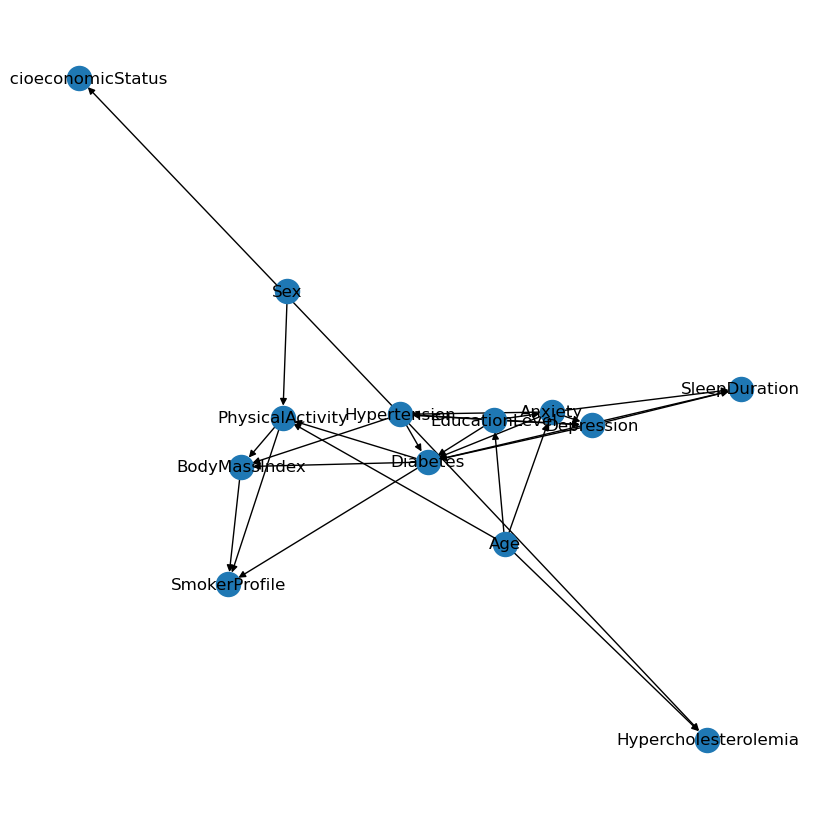

In [17]:
plt.figure(figsize=(8, 8))
nx.draw(nx.DiGraph(best_balanced_model.edges()), with_labels=True)
plt.draw()
print(best_balanced_model.edges())

# Paramether Learning - Using the DAG to get the BPDs

### No SMOTE

In [18]:
bm = BayesianNetwork()
bm.add_nodes_from(nodes)
bm.add_edges_from(best_model.edges)

In [19]:
bm.fit(df_train, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

In [20]:
def print_full(cpd):
    backup = TabularCPD._truncate_strtable
    TabularCPD._truncate_strtable = lambda self, x: x
    print(cpd)
    TabularCPD._truncate_strtable = backup

for c in bm.get_cpds():
    print_full(c)


+---------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+---------------------------+---------------------------+---------------------------+----------------------------+----------------------------+----------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+---------------------------+---------------------------+---------------------------+----------------------------+----------------------------+----------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+---------------------------+---------------------------+---------------------------+----------------------------+----------------------------+----------------------------+--------------

In [21]:
infer = VariableElimination(bm)

for Age in df_train['Age'].unique(): # sem relacao, justificar. # Pesquisa Cotas a dormir
    print(Age)
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

54-64
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8928 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1050 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0022 |
+-------------------------+----------------------+
24-34
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8928 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1050 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0022 |
+-------------------------+----------------------+
34-44
+-------------------------+----------------------+
| SleepDurati

In [22]:
for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'SmokerProfile': Profile}))

for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'SmokerProfile': Profile}))

for Profile in df_train['SmokerProfile'].unique():
    print(Profile, 'Hypertension')
    print(infer.query(['Hypertension'], evidence={'SmokerProfile': Profile}))

Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9469 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0531 |
+---------------+-----------------+
Non_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9564 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0436 |
+---------------+-----------------+
Ex_Smoker Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9557 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0443 |
+---------------+-----------------+
Smoker Hypercholesterolemia
+---------------------------+-----------------------------+
| Hypercholesterolemia      |   phi(Hypercholesterolemia) |
+===========================+============

In [23]:
# Dar ganda lengalenga

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Diabetes')
    print(infer.query(['Diabetes'], evidence={'BodyMassIndex': Profile}))

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypercholesterolemia')
    print(infer.query(['Hypercholesterolemia'], evidence={'BodyMassIndex': Profile}))

for Profile in df_train['BodyMassIndex'].unique():
    print(Profile, 'Hypertension Sex')
    print(infer.query(['Hypertension'], evidence={'BodyMassIndex': Profile}))

Overweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9546 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0454 |
+---------------+-----------------+
Obese Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9554 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0446 |
+---------------+-----------------+
Normal Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9526 |
+---------------+-----------------+
| Diabetes(Yes) |          0.0474 |
+---------------+-----------------+
Underweight Diabetes
+---------------+-----------------+
| Diabetes      |   phi(Diabetes) |
+===============+=================+
| Diabetes(No)  |          0.9420 |
+---------------+-----------

In [24]:
for Level in df_train['EducationLevel'].unique():
    for status in df_train['SocioeconomicStatus'].unique():
        print(Level, status)
        print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

print("starts")
for Level in df_train['SocioeconomicStatus'].unique():
    print(Level)
    print(infer.query(['Depression'], evidence={'EducationLevel': Level, 'SocioeconomicStatus': status}))

2 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9928 |
+-----------------+-------------------+
| Depression(Yes) |            0.0072 |
+-----------------+-------------------+
2 1
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9928 |
+-----------------+-------------------+
| Depression(Yes) |            0.0072 |
+-----------------+-------------------+
2 2
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |            0.9928 |
+-----------------+-------------------+
| Depression(Yes) |            0.0072 |
+-----------------+-------------------+
3 3
+-----------------+-------------------+
| Depression      |   phi(Depression) |
+=================+===================+
| Depression(No)  |     

### With SMOTE

In [25]:
bm_resampled = BayesianNetwork()
bm_resampled.add_nodes_from(nodes)
bm_resampled.add_edges_from(best_model.edges)

In [26]:
bm_resampled.fit(df_resampled, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=1)

In [27]:
infer = VariableElimination(bm_resampled) # We can not easily decode the data...

for Age in df_resampled['Age'].unique(): 
    print(infer.query(['SleepDuration'], evidence={'Age': Age}))

+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8097 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1433 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0470 |
+-------------------------+----------------------+
+-------------------------+----------------------+
| SleepDuration           |   phi(SleepDuration) |
+=========================+======================+
| SleepDuration(6-9hours) |               0.8178 |
+-------------------------+----------------------+
| SleepDuration(<6hours)  |               0.1397 |
+-------------------------+----------------------+
| SleepDuration(>9hours)  |               0.0425 |
+-------------------------+----------------------+
+-------------------------+----------------------+
| SleepDuration           |   p

Inference with smote isn't working due to an issue with the way we are encoding our values.

# Evaluating The Network

## No Smote

In [28]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

X_train_diabetes = df_train.drop(columns='Diabetes')
y_train_diabetes = df_test['Diabetes']

y_pred = bm.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.95      1.00      0.98      1224
         Yes       0.00      0.00      0.00        58

    accuracy                           0.95      1282
   macro avg       0.48      0.50      0.49      1282
weighted avg       0.91      0.95      0.93      1282

[[1224    0]
 [  58    0]]


In [29]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.83      0.99      0.90      1052
         Yes       0.64      0.07      0.13       230

    accuracy                           0.83      1282
   macro avg       0.73      0.53      0.51      1282
weighted avg       0.80      0.83      0.76      1282

[[1043    9]
 [ 214   16]]


In [30]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.70      0.88      0.78       795
         Yes       0.66      0.37      0.47       487

    accuracy                           0.69      1282
   macro avg       0.68      0.63      0.63      1282
weighted avg       0.68      0.69      0.66      1282

[[701  94]
 [307 180]]


## With SMOTE

In [31]:
X_test_diabetes = df_test.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

In [32]:
X_resampled_diabetes = df_resampled.drop(columns='Diabetes')
y_test_diabetes = df_test['Diabetes']

y_pred = bm_resampled.predict(X_test_diabetes)

print(classification_report(y_test_diabetes, y_pred, zero_division=False))
print(confusion_matrix(y_test_diabetes, y_pred))

  0%|          | 0/808 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.96      0.97      0.96      1224
         Yes       0.16      0.12      0.14        58

    accuracy                           0.93      1282
   macro avg       0.56      0.55      0.55      1282
weighted avg       0.92      0.93      0.93      1282

[[1187   37]
 [  51    7]]


In [33]:
X_test_hypertension = df_test.drop(columns='Hypertension')
y_test_hypertension = df_test['Hypertension']
y_pred = bm_resampled.predict(X_test_hypertension)

print(classification_report(y_test_hypertension, y_pred))
print(confusion_matrix(y_test_hypertension, y_pred))


  0%|          | 0/741 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.83      0.98      0.90      1052
         Yes       0.52      0.07      0.13       230

    accuracy                           0.82      1282
   macro avg       0.67      0.53      0.51      1282
weighted avg       0.77      0.82      0.76      1282

[[1036   16]
 [ 213   17]]


In [34]:
X_test_cholesterolemia = df_test.drop(columns='Hypercholesterolemia')
y_test_cholesterolemia = df_test['Hypercholesterolemia']
y_pred = bm_resampled.predict(X_test_cholesterolemia)
print(classification_report(y_test_cholesterolemia, y_pred))
print(confusion_matrix(y_test_cholesterolemia, y_pred))

  0%|          | 0/704 [00:00<?, ?it/s]

              precision    recall  f1-score   support

          No       0.69      0.89      0.78       795
         Yes       0.67      0.36      0.47       487

    accuracy                           0.69      1282
   macro avg       0.68      0.63      0.62      1282
weighted avg       0.69      0.69      0.66      1282

[[710  85]
 [313 174]]


In [35]:
df_test.count()

Age                     1282
Anxiety                 1282
BodyMassIndex           1282
Depression              1282
Diabetes                1282
EducationLevel          1282
Hypercholesterolemia    1282
Hypertension            1282
PhysicalActivity        1282
Sex                     1282
SleepDuration           1282
SmokerProfile           1282
SocioeconomicStatus     1282
dtype: int64

In [36]:
df_train.count()

Age                     3845
Anxiety                 3845
BodyMassIndex           3845
Depression              3845
Diabetes                3845
EducationLevel          3845
Hypercholesterolemia    3845
Hypertension            3845
PhysicalActivity        3845
Sex                     3845
SleepDuration           3845
SmokerProfile           3845
SocioeconomicStatus     3845
dtype: int64

In [37]:
df_resampled.count()

Age                     4402
Anxiety                 4402
BodyMassIndex           4402
Depression              4402
EducationLevel          4402
Hypercholesterolemia    4402
Hypertension            4402
PhysicalActivity        4402
Sex                     4402
SleepDuration           4402
SmokerProfile           4402
SocioeconomicStatus     4402
Diabetes                4402
dtype: int64